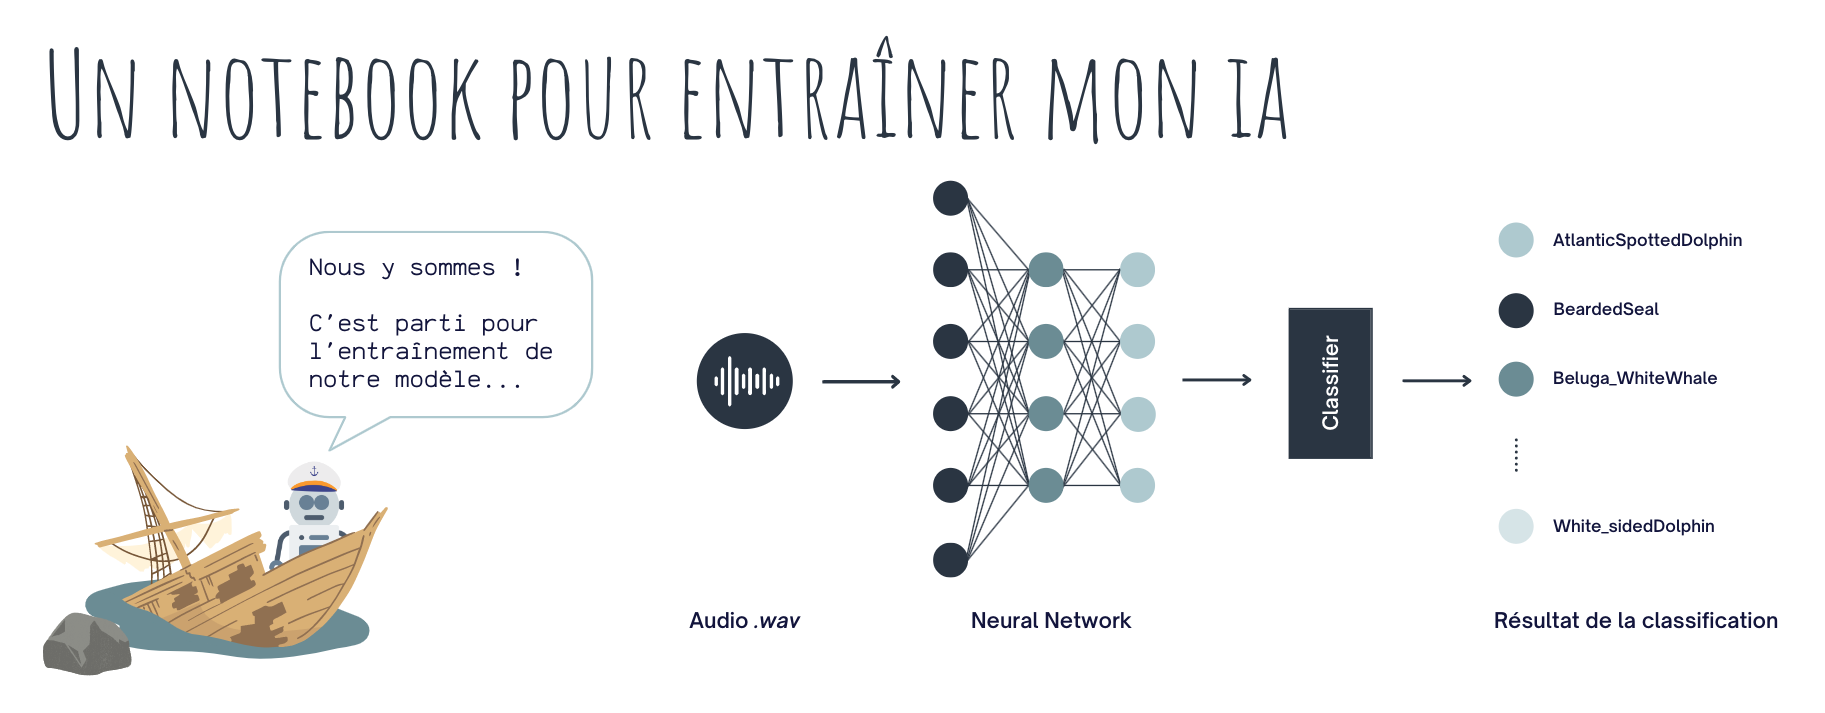

## 1. Importation des bibliothèques Python

In [ ]:
# audio signal analysis
import librosa
import librosa.display

# command shell for interactive computing
import IPython

# display graphs
import matplotlib.pyplot as plt

# matrices or multidimensional arrays handling 
import numpy as np

# data handling and analysis
import pandas as pd

# data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# define and train an AI model
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential

## 2. Test sur un son 

In [ ]:
test_sound = "/workspace/data/marine-mammal-sound-test1.wav"

- Chargement et décodage du son :

In [ ]:
data, sr = librosa.load(test_sound)
print(type(data), type(sr))

In [ ]:
librosa.load(test_sound ,sr = sr)

- Jouer un son avec `IPython.display.Audio` :

In [ ]:
IPython.display.Audio(data, rate = sr)

- Waveforms :

Représentations visuelles du son sous forme de temps sur l'axe des x et d'amplitude sur l'axe des y. 

Elles permettent une analyse rapide des données audio.

In [ ]:
plt.show(librosa.display.waveplot(data))

## 3. Prétraitement des données

Lien vers le dataset : [Watkins marine mammal sound database](https://cis.whoi.edu/science/B/whalesounds/index.cfm)

### a. Fichier `data.csv`

Pour entraîner le modèle, les données doivent être pré-traitées. Tout d'abord, il faut convertir les fichiers `.wav` en fichier `.csv`.

- Définition des colonnes :

In [ ]:
header = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean \
        spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean \
        perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean mfcc2_var mfcc3_mean mfcc3_var mfcc4_mean mfcc4_var label".split()

- Création du fichier `data.csv` :

In [ ]:
file = open("data.csv", "w", newline = "")
with file:
    writer = csv.writer(file)
    writer.writerow(header)

- Définir la chaîne de caractère des nom de mammifères marins (45):

> 45 mammifères marins différents <=> 45 classes

In [ ]:
marine_mammals = "AtlanticSpottedDolphin BeardedSeal Beluga_WhiteWhale BlueWhale BottlenoseDolphin Boutu_AmazonRiverDolphin BowheadWhale ClymeneDolphin \
        Commerson'sDolphin CommonDolphin Dall'sPorpoise DuskyDolphin FalseKillerWhale Fin_FinbackWhale FinlessPorpoise Fraser'sDolphin Grampus_Risso'sDolphin \
        GraySeal GrayWhale HarborPorpoise HarbourSeal HarpSeal Heaviside'sDolphin HoodedSeal HumpbackWhale IrawaddyDolphin JuanFernandezFurSeal KillerWhale \
        LeopardSeal Long_FinnedPilotWhale LongBeaked(Pacific)CommonDolphin MelonHeadedWhale MinkeWhale Narwhal NewZealandFurSeal NorthernRightWhale \
        PantropicalSpottedDolphin RibbonSeal RingedSeal RossSeal Rough_ToothedDolphin SeaOtter Short_Finned(Pacific)PilotWhale SouthernRightWhale SpermWhale".split()

- Transformer chaque son `.wav` en une ligne du fichier `.csv` :

In [ ]:
for animal in marine_mammals:

    for filename in os.listdir(f"/workspace/data/{animal}/"):

        sound_name = f"/workspace/data/{animal}/{filename}"
        y, sr = librosa.load(sound_name, mono = True, duration = 30)
        chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
        rmse = librosa.feature.rms(y = y)
        spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
        spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
        rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y = y, sr = sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

        for e in mfcc:
            to_append += f' {np.mean(e)}'

        to_append += f' {animal}'
        file = open('data.csv', 'a', newline = '')

        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

- Afficher le fichier `data.csv` :

In [ ]:
df = pd.read_csv('/workspace/data/data.csv')
df.head()

In [ ]:
# dataframe types
df.dtypes

### b. Extraction des caractéristiques

- Extraction de caractéristiques (nécessaire avant de lancer l'entraînement)
- Objectif : définir les **entrées** et **sorties** du réseau neuronal

- **SORTIE** (y) : dernière colonne qui est le `label`.

Nous ne pouvons pas utiliser directement du texte pour l'entraînement => nous allons encoder ces labels avec la fonction **LabelEncoder()** de **sklearn.preprocessing**.

Avant de pouvoir exécuter un modèle, nous devons convertir ce type de données textuelles catégorielles en données numériques que le modèle peut comprendre.

In [ ]:
class_list = df.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(class_list)
print("y: ", y)

- **INPUTS** (X) : toutes les autres colonnes sont des paramètres d'entrée du réseau neuronal, sauf le nom de fichier.

Nous supprimons la première colonne qui ne fournit aucune information pour l'apprentissage (le nom de fichier) et la dernière qui correspond à la sortie.

In [ ]:
input_parameters = df.iloc[:, 1:27]
scaler = StandardScaler()
X = scaler.fit_transform(np.array(input_parameters))
print("X:", X)

## 4. Séparation des données pour l'entraînement

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Construction du modèle

La première étape consiste à construire le modèle et à afficher le résumé.

Pour le modèle **ANN**...
- toutes les couches cachées utilisent une fonction d'activation **ReLU**.

*Cette fonction permet d’effectuer un filtre sur nos données. Elle laisse passer les valeurs positives (x > 0) dans les couches suivantes du réseau de neurones. Elle est utilisée presque partout mais surtout pas dans la couche final, elle est utilisée dans les couches intermédiaires.*

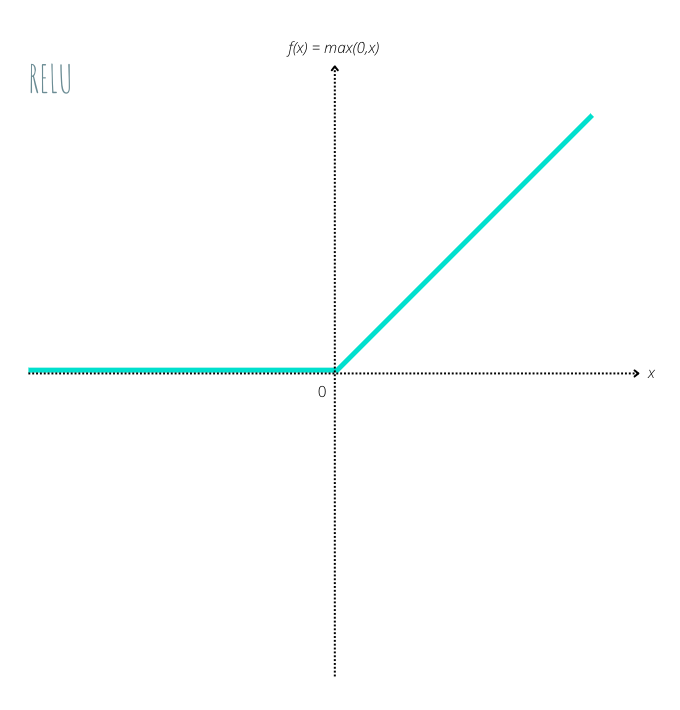

- la couche de sortie utilise une fonction **Softmax**.

*La fonction Softmax permet de transformer un vecteur réel en vecteur de probabilité. On l’utilise souvent dans la couche finale d’un modèle de classification, notamment pour les problèmes multiclasse.*

*Un Softmax est en quelque sorte une combinaison de Sigmoïdes. La somme des valeurs issues de laclassification est égale à 1.*

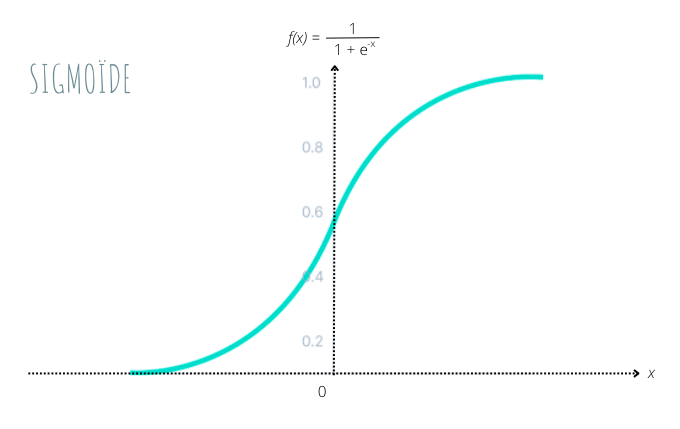

- un **Dropout** est utilisé pour éviter l'overfitting.

*Le terme  » Dropout  » fait référence à la suppression de neurones dans les couches d’un modèle de Deep Learning. On désactive temporairement certains neurones dans le réseau, ainsi que toutes ses connexions entrantes et sortantes*

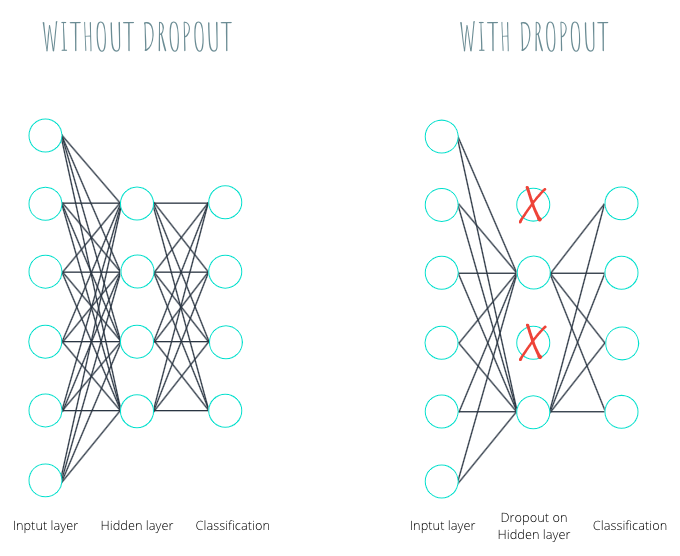

**Schéma global de l'ANN :**

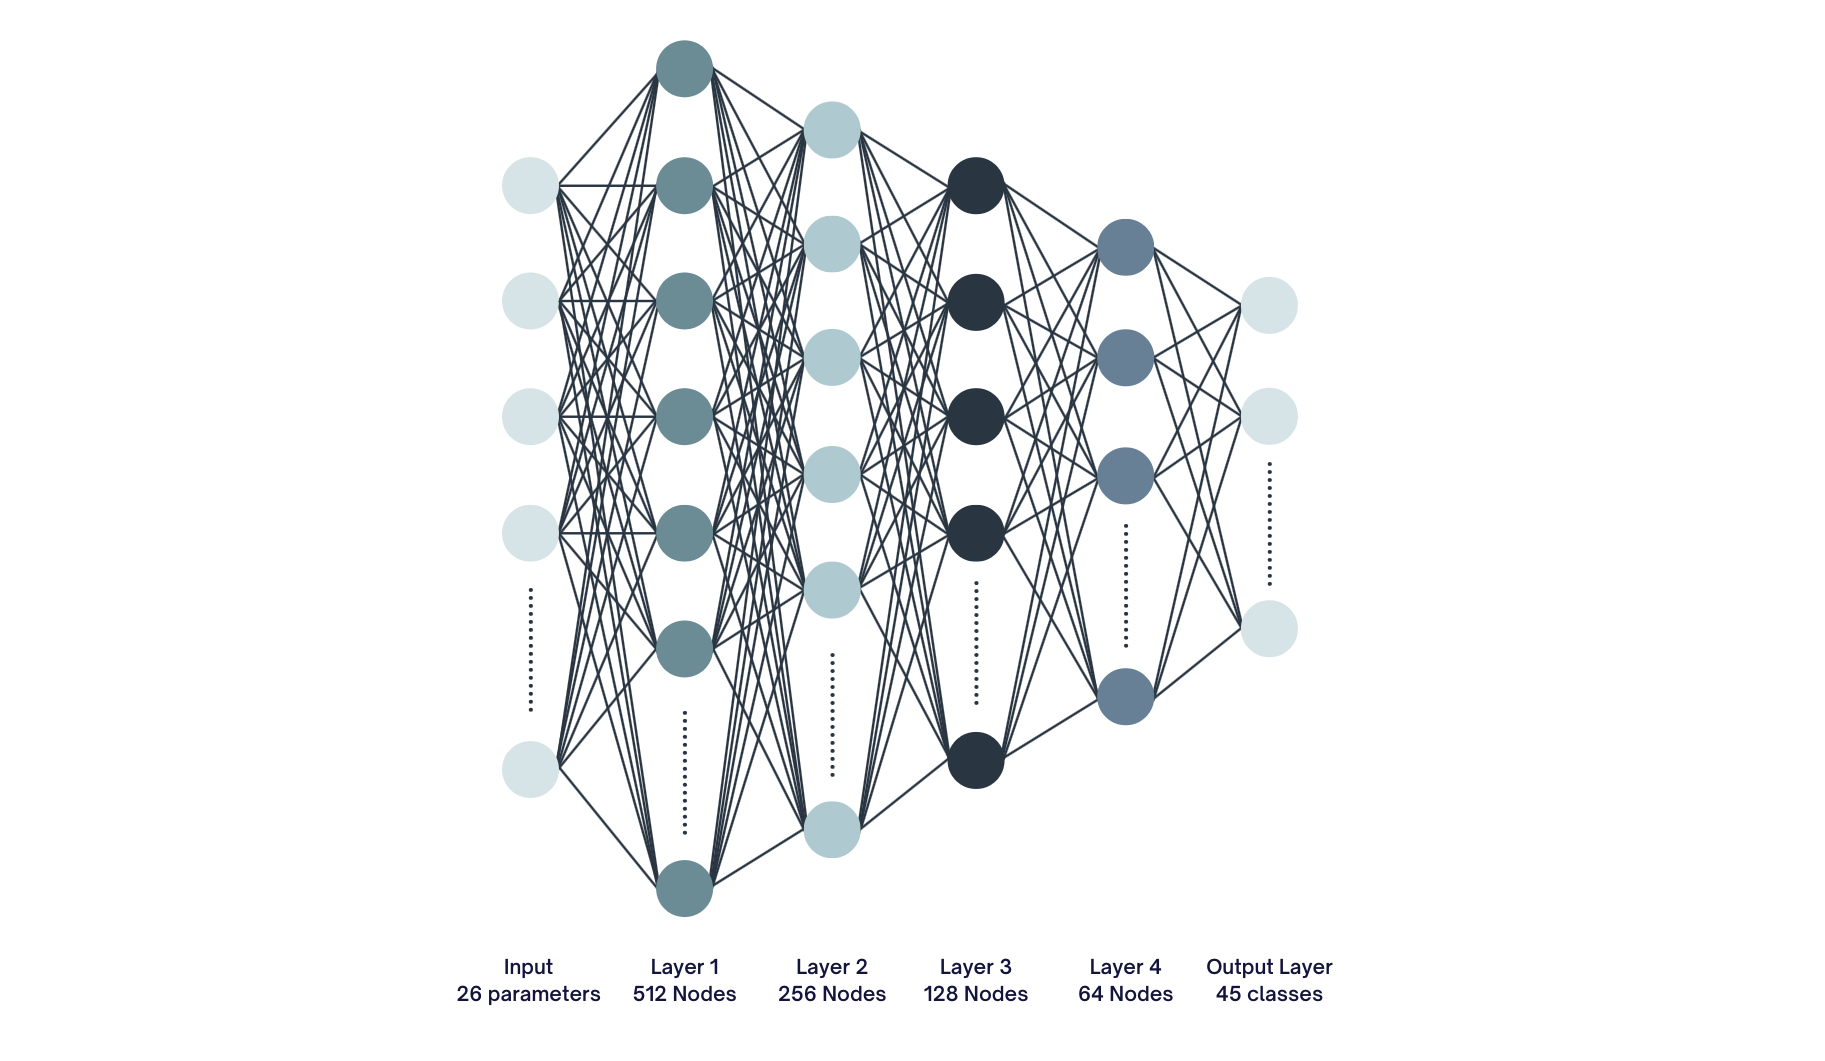

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(45, activation = 'softmax'),
])

print(model.summary())

## 5. Entraînement et évaluation du modèle

L'optimiseur **Adam** est utilisé pour entraîner le modèle sur 100 époques. Ce choix a été fait car il nous permet d'obtenir de meilleurs résultats.

- Calcul de la perte avec la fonction **sparse_categorical_crossentropy**

In [ ]:
def trainModel(model,epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
    return model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epochs, batch_size = batch_size)

- Lancement de l'entraînement :

In [ ]:
model_history = trainModel(model = model, epochs = 100, optimizer = 'adam')

- Affichage de la courbe de perte - **loss** :

In [ ]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

- Affichage des courbes de précision - **accuracy** :

In [ ]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

## 7. Exporter le modèle pour une future inférence

In [ ]:
model.save('/workspace/data/ai-model/model-marine-mammal-sounds-classification')

In [ ]:
# my_model directory
%ls /workspace/data/ai-model/model-marine-mammal-sounds-classification

In [ ]:
model = tf.keras.models.load_model('/workspace/data/ai-model/model-marine-mammal-sounds-classification')
model.summary()